# Initial exploration of LSST-reprocessed Stripe82 data

We're interested in finding low surface brightness, high angular size satellite galaxies. The LSST reprocessing of SDSS stripe 82 is interesting, because they put a lot of effort into reducing the background to reveal exactly this sort of feature. Let's see what we can find, just masking out the detected objects and rebinning to large pixel scale (to accumulate the extended satellite's flux).

### Getting the data

The LSST DM-stack reprocessed SDSS stripe 82 images are not available over the web, but there's a test one on Nidever's website. Let's download that one - its 26Mb or so.

In [1]:
from __future__ import print_function
import astropy.io.fits as pyfits
import numpy as np
import os
import urllib
import astropy.visualization as viz
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) 

In [2]:
remotedir = 'https://lavinia.as.arizona.edu/~dnidever/FuzzyBlobs/'
FITSfile = 'coadd-g-0-400,0.fits.gz'

url = os.path.join(remotedir, FITSfile)
if not os.path.isfile(FITSfile):
    urllib.urlretrieve(url, FITSfile)

!du -h $FITSfile
    
# Replaces !wget https://lavinia.as.arizona.edu/~dnidever/FuzzyBlobs/coadd-g-0-400,0.fits.gz

 26M	coadd-g-0-400,0.fits.gz


### Image inspection

The object detection regions are contained in the mask extension of the image files - let's take a look.

(1937, 2060)


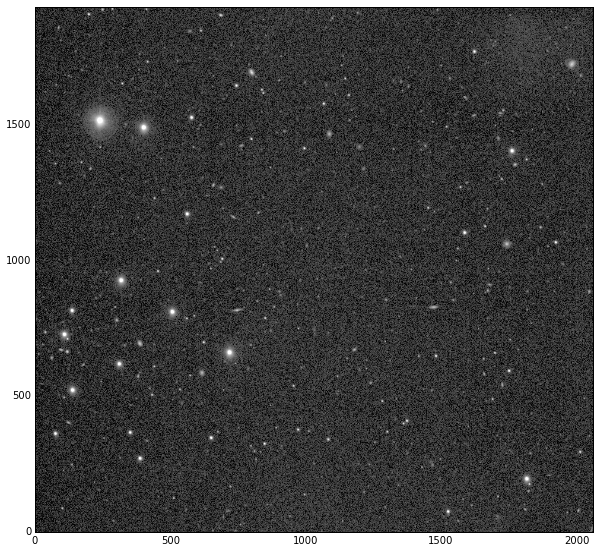

In [3]:
fits = pyfits.open(FITSfile)
image = fits[1].data
print(image.shape)
plt.imshow(viz.scale_image(image, scale='log', min_cut=15, max_cut=100), cmap='gray', origin='lower');

Cool - see that fuzzy blob in the top right hand corner? That's the *kind* of thing we're after. How big is this field?

In [4]:
print('The field of view is ',2060*0.4 / 60.0,' arcmin wide')

The field of view is  13.7333333333  arcmin wide


(1937, 2060)


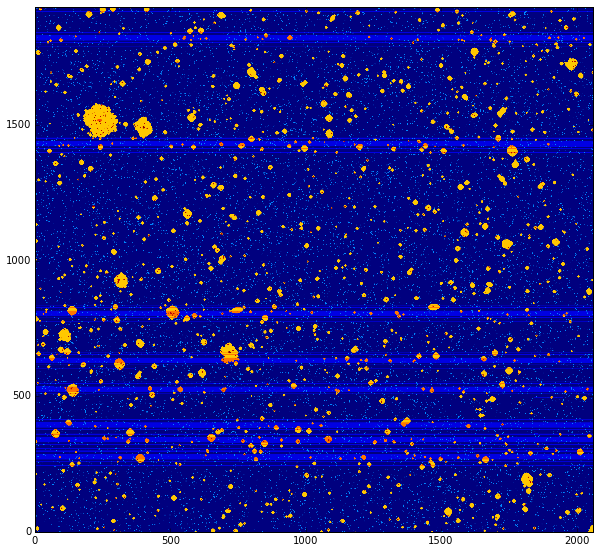

In [5]:
mask = fits[2].data
print(mask.shape)
plt.imshow(mask, cmap='jet', origin='lower');

### Masking out the objects

We need to figure out the threshold to use, and then apply the mask to the image. 

In [6]:
print(np.min(mask),np.max(mask))

0.0 46.0


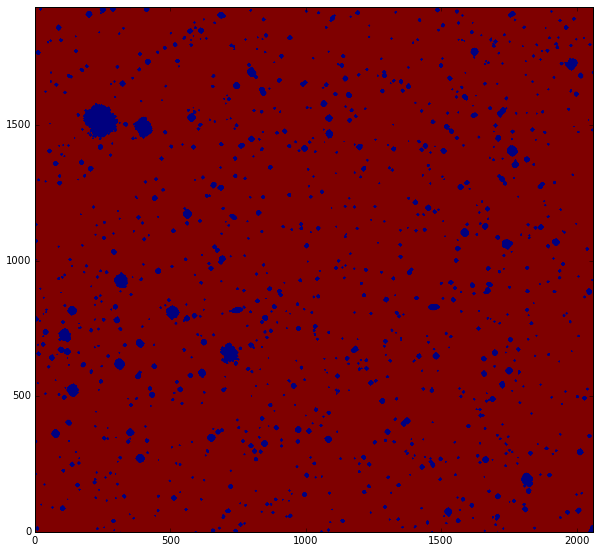

In [7]:
# threshold = 20
# objects = (mask >= threshold)

threshold = 32
objects = np.bitwise_and(np.int16(mask),threshold) == threshold

mask[objects] = 0
mask[np.logical_not(objects)] = 1
plt.imshow(mask, cmap='jet', origin='lower');

Great! Now let's look at the image with objects masked out:

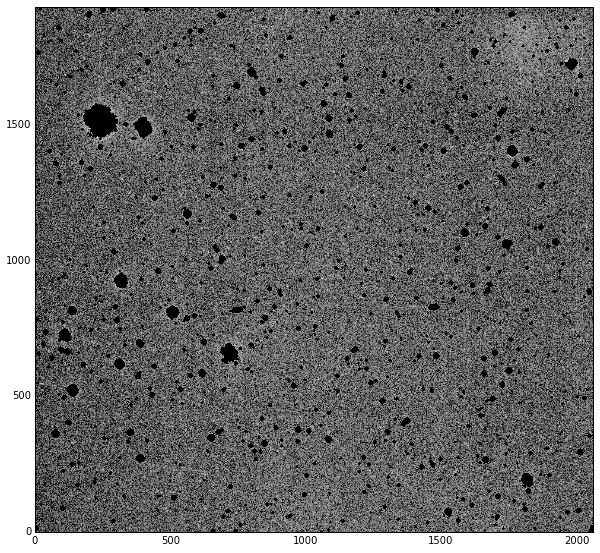

In [8]:
plt.imshow(viz.scale_image(mask*image, scale='log', min_cut=15, max_cut=100), cmap='gray', origin='lower');

Hmm: the object regions are big, but the bright stars extend a little beyond their boundaries. This could be a problem. Let's try inpainting with noise before rebinning by a factor of 70, to 30 arcsec pixels.

In [45]:
masked_image = mask*image

# Subtract off background and re-apply mask:
background = np.sum(masked_image)/(1.0*np.sum(mask))
masked_image = (masked_image - background)*mask

# Compute std dev:
rms = np.sqrt(np.sum(masked_image*masked_image)/(1.0*np.sum(mask)))

print("Background =",background,"+/-",rms)

Background = 15.3048427086 +/- 0.323579508042


In [48]:
noisefill = (1.0 - mask)*np.random.normal(loc=background,scale=rms,size=masked_image.shape)

inpainted_image = (masked_image + background)*mask + noisefill

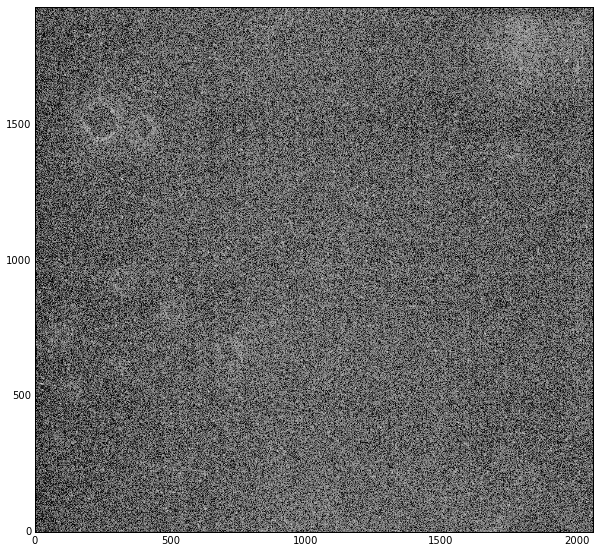

In [50]:
plt.imshow(viz.scale_image(inpainted_image, scale='log', min_cut=15, max_cut=100), cmap='gray', origin='lower');

### Rebinning

In [59]:
bin = 70
nx = image.shape[0] // bin
ny = image.shape[1] // bin

field = 2060*0.4 # arcsec
pixscale = field / (1.0*nx)
print('Rebinning to',round(pixscale,2),'arcsec per pixel')

image = inpainted_image.copy()
masked = False

trimmed_image = image[0:nx*bin, 0:ny*bin]
rebinned_trimmed_image = trimmed_image.reshape(nx, bin, ny, bin)
coadded_rebinned_trimmed_image = rebinned_trimmed_image.sum(axis=3).sum(axis=1)

if not masked:
    mask = image*0.0 + 1.0
    
trimmed_mask = mask[0:nx*bin, 0:ny*bin]
rebinned_trimmed_mask = trimmed_mask.reshape(nx, bin, ny, bin)
coadded_rebinned_trimmed_mask = rebinned_trimmed_mask.sum(axis=3).sum(axis=1)
bd = (coadded_rebinned_trimmed_mask == 0)
coadded_rebinned_trimmed_mask[bd] = 1

new_image = coadded_rebinned_trimmed_image / (1.0*coadded_rebinned_trimmed_mask)

mean,stdev = np.mean(new_image),np.std(new_image)
print("Rebinned image has mean +/ stdev =",mean,"+/-",stdev)

Rebinning to 30.52 arcsec per pixel
Rebinned image has mean +/ stdev = 15.3046933834 +/- 0.0405240846518


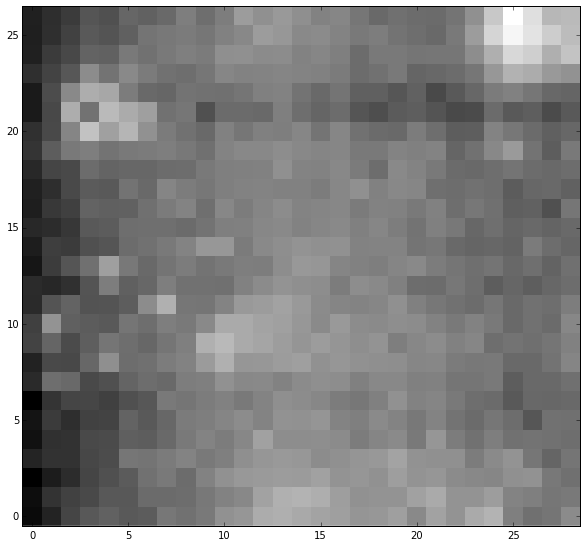

In [62]:
plt.imshow(viz.scale_image(new_image, scale='log', min_cut=15, max_cut=100), cmap='gray', origin='lower', interpolation='none')

Not much gained from inpainting, except that edges of bright stars now appear as *small* features instead of big ones.

Anyway, there's our object in the top righthand corner. The edges of the masked out bright stars are still a problem, but maybe not an insurmountable one. Perhaps we'll need to grow the masked regions by a few pixels, I think. Still - proof of concept?